# **Market Stock Prediction Using Batch Learning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly

In [31]:
data = pd.read_csv('BL_data_BTCUSDT.csv', index_col=0)
data.index = pd.to_datetime(data['date'])
data = data.drop(columns=['date'])
data.shape

(1000, 5)

In [32]:
data.head()

,open,high,low,close,volume
date,,,,,
2022-04-03,45810.99,47444.11,45530.92,46407.35,33394.67794
2022-04-04,46407.36,46890.71,45118.00,46580.51,44641.87514
2022-04-05,46580.50,47200.00,45353.81,45497.55,42192.74852
2022-04-06,45497.54,45507.14,43121.00,43170.47,60849.32936
2022-04-07,43170.47,43900.99,42727.35,43444.19,37396.54156


In [33]:
data.index.max(), data.index.min() 

(Timestamp('2024-12-27 00:00:00'), Timestamp('2022-04-03 00:00:00'))

What we want to predict/forcast is the close price.

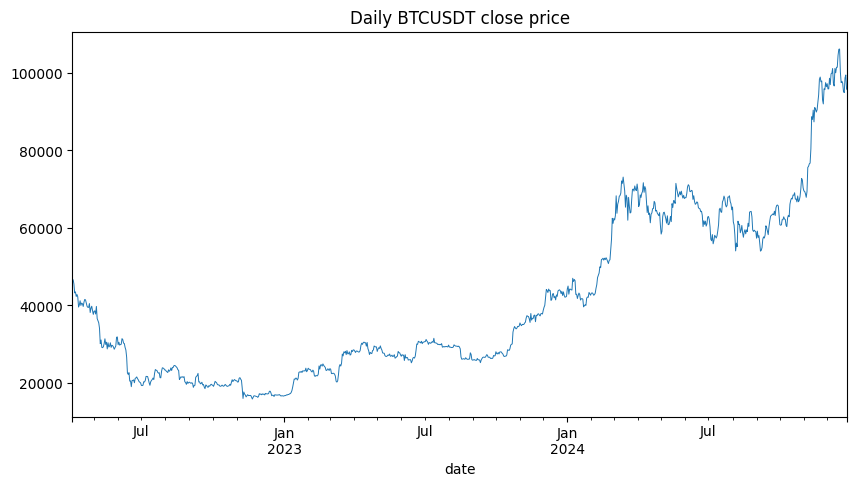

In [35]:
plt.figure(figsize=(10, 5))
data['close'].plot(linewidth=0.7)
plt.title("Daily BTCUSDT close price")
plt.show()


In [36]:
data['close'].describe()


count      1000.000000
mean      40779.622580
std       21436.476876
min       15781.290000
25%       23545.567500
50%       30291.730000
75%       60639.335000
max      106133.740000
Name: close, dtype: float64

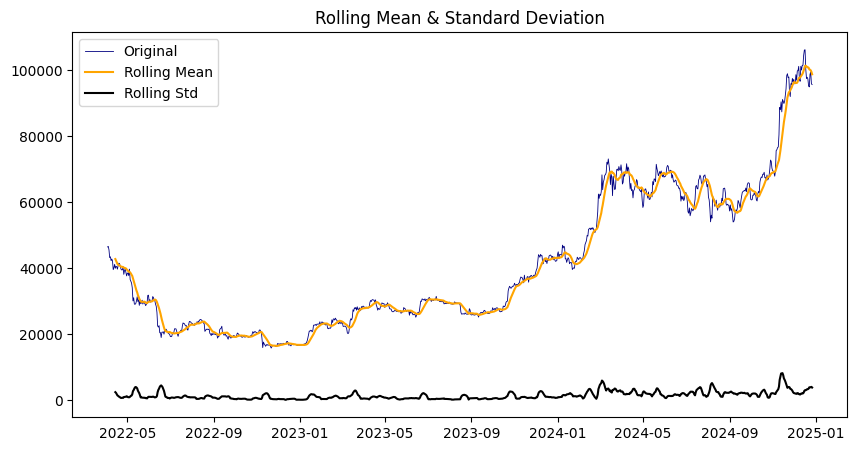

Results of Dickey-Fuller Test:
Test Statistic                   1.026381
p-value                          0.994537
#Lags Used                      20.000000
Number of Observations Used    979.000000
Critical Value (1%)             -3.437047
Critical Value (5%)             -2.864497
Critical Value (10%)            -2.568344
dtype: float64


In [40]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='navy',label='Original', linewidth=0.6)
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') #autolag = 'AIC' is the Akaike Information Criterion
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['close'])


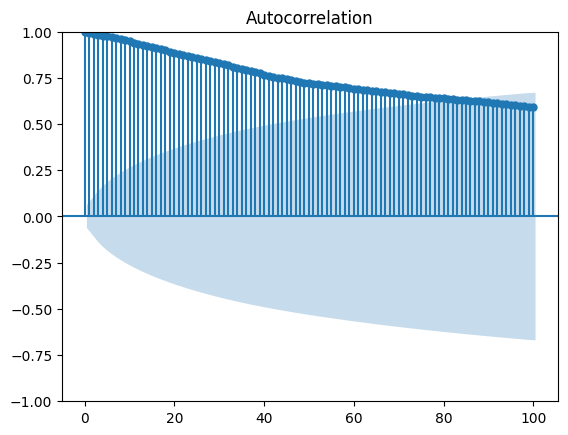

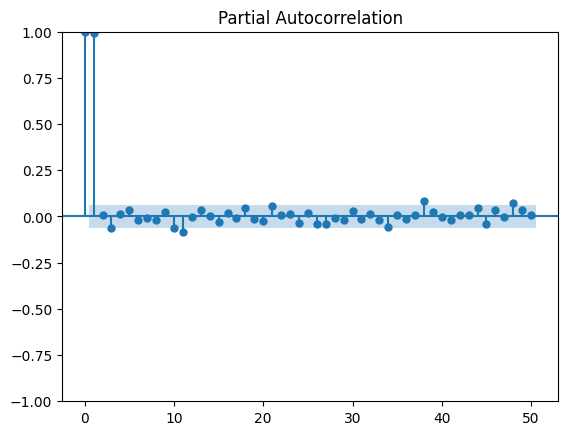

In [41]:
plot_acf(data['close'], lags=100)
plt.show()
plot_pacf(data['close'], lags=50)
plt.show()


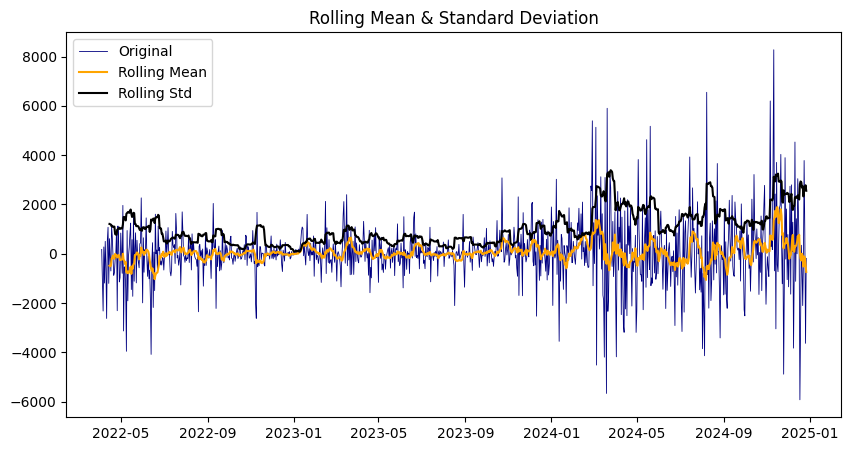

Results of Dickey-Fuller Test:
Test Statistic                -7.429520e+00
p-value                        6.415520e-11
#Lags Used                     1.900000e+01
Number of Observations Used    9.790000e+02
Critical Value (1%)           -3.437047e+00
Critical Value (5%)           -2.864497e+00
Critical Value (10%)          -2.568344e+00
dtype: float64


In [42]:
diff = data['close'].diff().dropna()
test_stationarity(diff)


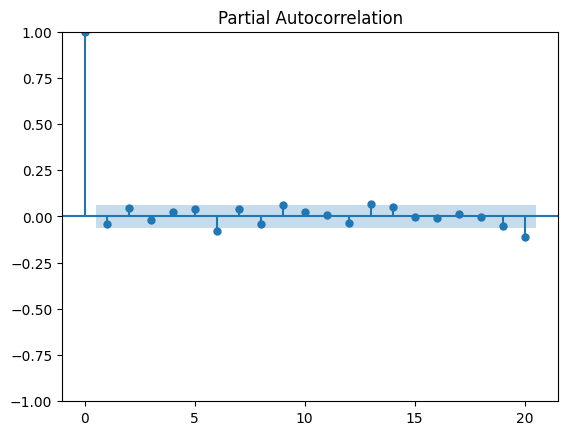

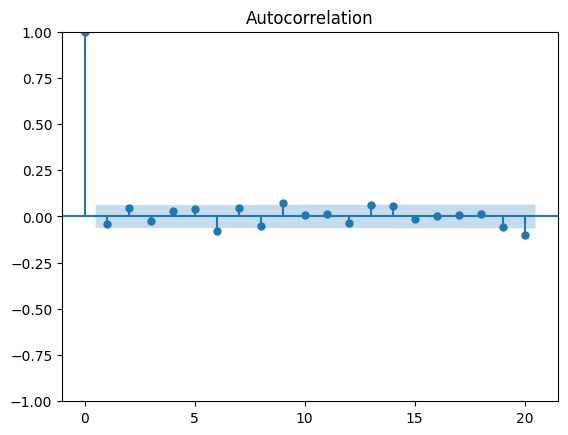

In [43]:
plot_pacf(diff, lags=20)
plt.show()
plot_acf(diff, lags=20)
plt.show()

So we will adopt a model : p = 1, d = 1, q = 1

In [56]:
y_train, y_test = data['close'][:int(len(data)*0.7)], data['close'][int(len(data)*0.7):]
x_train, x_test = data.drop('close', axis=1)[:int(len(data)*0.7)], data.drop('close', axis=1)[int(len(data)*0.7):]

In [57]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 4), (300, 4), (700,), (300,))

In [58]:
y_train.head()

date
2022-04-03    46407.35
2022-04-04    46580.51
2022-04-05    45497.55
2022-04-06    43170.47
2022-04-07    43444.19
Name: close, dtype: float64

In [92]:
import plotly.graph_objects as go
import numpy as np
# PLOT PREDICTIONS 
def Go_plot_predictions(model_fit, data, y_train, y_test, x_test):
    fig_predictions = go.Figure()

    # Real data
    fig_predictions.add_trace(go.Scatter(
        y=data['close'], 
        mode='lines', 
        line=dict(color='black', width=1.3),
        name='Real'
    ))

    # Predicted data
    fitted_values = model_fit.fittedvalues
    forecast_values = model_fit.forecast(steps=len(y_test), exog=x_test.values)
    predicted = np.concatenate([fitted_values, forecast_values])
    fig_predictions.add_trace(go.Scatter(
        y=predicted,
        mode='lines',
        line=dict(color='orange', width=1.3),
        name='Predicted'
    ))

    # Layout settings
    fig_predictions.update_layout(
        title='ARIMAX Model Forecasting of BTCUSDT Close Price',
        xaxis_title='Time',
        yaxis_title='Value',
        template='plotly_white',
        height=600,
        width=900
    )
    # divide the graph into two parts a left part for training data and a right part for testing data, fill the part with different colors
    fig_predictions.add_shape(
        type="rect",
        x0=0,
        x1=len(y_train),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightSkyBlue",
        opacity=0.1,
        layer="below", 
        name='Training phase'
    )

    fig_predictions.add_shape(
        type="rect",
        x0=len(y_train),
        x1=len(data),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightCoral",
        opacity=0.1,
        layer="below", 
        name='Testing phase'
    )

    fig_predictions.show()
    # PLOT RESIDUALS
    fig_residuals = go.Figure()

    # Residuals data
    fig_residuals.add_trace(go.Scatter(
        y= np.concatenate([model_fit.resid, - forecast_values + y_test]),
        mode='lines',
        line=dict(color='purple', width=0.7),
        name='Residuals'
    ))

    # Layout settings
    fig_residuals.update_layout(
        title='ARIMA Model Residuals',
        xaxis_title='Time',
        yaxis_title='Residuals',
        template='plotly_white',
        height=600,
        width=850
    )

    fig_residuals.show()

In [96]:
# metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def metrics(y_true, y_pred):
    mse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, mape

    - Seasonal ARIMA model

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y_train.values, order=(1,1,1))#, exog= x_train.values)
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5677.508
Date:                Sun, 12 Jan 2025   AIC                          11361.017
Time:                        19:03:59   BIC                          11374.666
Sample:                             0   HQIC                         11366.293
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5769      1.176      0.491      0.624      -1.728       2.882
ma.L1         -0.5669      1.192     -0.475      0.634      -2.904       1.770
sigma2      6.565e+05      2e+04     32.884      0.000    6.17e+05    6.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):              1058.77
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.00
Prob(H) (two-sided):                  0.95   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:

Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [98]:
mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test)))
print("Test metrics FOR SARIMA:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMA:
RMSE: 14596.883098253686
MAE: 9044.622990554346
R2: -0.3639980336924822
MAPE: 0.11075322982783829


    - ARIMAX

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMAX(y_train.values, order=(1,1,1), exog= x_train.values)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5011.834
Date:                Sun, 12 Jan 2025   AIC                          10037.669
Time:                        19:06:32   BIC                          10069.516
Sample:                             0   HQIC                         10049.980
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5330      0.024    -22.069      0.000      -0.580      -0.486
x2             0.7822      0.022     36.350      0.000       0.740       0.824
x3             0.7494      0.022     34.582      0.000       0.707       0.792
x4         -8.149e-05      0.000     -0.488      0.626      -0.000       0.000
ar.L1         -0.0958      0.048     -1.994      0.046      -0.190      -0.002
ma.L1         -0.9852      0.013    -78.590      0.000      -1.010      -0.961
sigma2      1.393e+05   1.96e-08   7.12e+12      0.000    1.39e+05    1.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               294.48
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.22e+29. Standard errors may be unstable.
"""

In [103]:
Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [104]:

mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test), exog=x_test.values))
print("Test metrics FOR SARIMAX:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMAX:
RMSE: 718.1669299706413
MAE: 526.8824369618059
R2: 0.9966982492110115
MAPE: 0.007648548809830397


We conclude that the multiple linear regression model is the best model for this dataset.

In [116]:
# Use prophet model to predict the future price of BTCUSDT
from prophet import Prophet

m = Prophet()

data_prophet = pd.DataFrame(y_train)
data_prophet['ds'] = data_prophet.index
data_prophet.columns = ['y', 'ds']
m.fit(data_prophet)


19:24:05 - cmdstanpy - INFO - Chain [1] start processing
19:24:05 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
y_test_prophet = pd.DataFrame(y_test)
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.columns = ['y', 'ds']

future = m.make_future_dataframe(periods=len(y_test))
future.tail()


,ds
995,2024-12-23
996,2024-12-24
997,2024-12-25
998,2024-12-26
999,2024-12-27


In [118]:
forcast = m.predict(future)
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
995,2024-12-23,99171.841598,73083.746351,124405.852818
996,2024-12-24,99402.990319,73057.628180,124433.891257
997,2024-12-25,99642.590769,73531.448380,125285.857788
998,2024-12-26,99710.808554,72686.979054,125099.200640
999,2024-12-27,99849.448480,73000.105866,126350.229317


In [123]:
from prophet.plot import plot_plotly, plot_components_plotly

fig = plot_plotly(m, forcast, xlabel='Date', ylabel='Close Price')
fig.show()


In [130]:
# plot using plotly the close price and the forecasted price
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['close'], 
    mode='lines', 
    line=dict(color='brown', width=1.3),
    name='Real'
))

fig.add_trace(go.Scatter(
    x=forcast['ds'], 
    y=forcast['yhat'], 
    mode='lines', 
    line=dict(color='orange', width=1.3),
    name='Predicted'
))

fig.update_layout(
    title='Prophet Model Forecasting of BTCUSDT Close Price',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly_white',
    height=600,
    width=900
)

fig.show()

    - LSTM :

In [ ]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.callbacks import EarlyStopping
import torch.optim as optim
from skorch import NeuralNetRegressor

import optuna